In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib import pylab
params = {'xtick.labelsize': 18,
 'ytick.labelsize': 18,
 'axes.titlesize' : 22,
 'axes.labelsize' : 20,
 'legend.fontsize': 18,
 'legend.title_fontsize': 22,
 'figure.titlesize': 24
 }
pylab.rcParams.update(params)

In [2]:
dataset = pd.read_csv("HW3_data.csv")
pd.set_option('display.max_columns', None)

In [3]:
dataset.head()

,patient_id,age,sex,weight,blood_type,current_location,num_of_siblings,happiness_score,household_income,conversations_per_day,sugar_levels,sport_activity,symptoms,pcr_date,PCR_01,PCR_02,PCR_03,PCR_04,PCR_05,PCR_06,PCR_07,PCR_08,PCR_09,PCR_10,contamination_level
0,263,16,F,64.1,A+,"('24.41288', '76.56719')",1,6,2,11,108,1,NaN,05-07-20,-4.598459,-11.204668,8.933243,247.230139,96.959642,11.792748,15.306437,3.929300,-214.682711,-56.344700,10.616771
1,1768,43,M,83.9,O+,"('55.75556', '60.70278')",1,9,6,2,116,0,NaN,12-02-20,2.090646,-11.118427,3.265275,57.421509,80.148318,7.616542,13.694204,5.016285,123.782023,-20.013564,13.940998
2,1374,44,M,101.5,A+,"('-26.93366', '29.24152')",0,8,1,3,112,2,cough;shortness_of_breath,26-07-20,3.742559,4.206684,2.014962,188.574377,229.499560,11.877267,-10.522185,4.745999,-65.856248,-24.400732,28.188468
3,1292,22,M,74.6,O+,"('48.78232', '9.17702')",1,6,3,1,109,0,NaN,07-11-20,-1.418033,-1.529560,7.941965,171.914488,315.920977,23.848574,-15.782997,4.323900,353.633326,-64.236355,22.976276
4,818,10,F,37.9,O+,"('39.78504', '-85.76942')",1,6,1,1,89,2,sore_throat,26-04-21,-3.234428,0.447605,9.567185,76.922690,215.179195,13.824784,-15.339006,11.384751,-41.861680,-62.901711,20.128380


In [24]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [25]:
# train-test split
from sklearn.model_selection import train_test_split
seed = 68 + 31 # sum of last two digits of IDs
train_raw, test_raw = train_test_split(dataset, test_size=0.2, random_state=seed)

In [26]:
# data preparation
from prepare import prepare_data

train = prepare_data(train_raw, train_raw)
test = prepare_data(train_raw, test_raw)

# small left-over mistake from the previous homework, didn't give format to pd.to_datetime. still works but will raise a warning

/home/dror/IML-Major3/prepare.py:96: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  data["pcr_date"] = pd.to_datetime(data["pcr_date"])
/home/dror/IML-Major3/prepare.py:96: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  data["pcr_date"] = pd.to_datetime(data["pcr_date"])
/home/dror/IML-Major3/prepare.py:96: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  data["pcr_date"] = pd.to_datetime(data["pcr_date"])
/home/dror/IML-Major3/prepare.py:96: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consist

In [27]:
train.head()

,patient_id,age,male,weight,num_of_siblings,happiness_score,household_income,conversations_per_day,sugar_levels,sport_activity,pcr_date,PCR_01,PCR_02,PCR_03,PCR_04,PCR_05,PCR_06,PCR_07,PCR_08,PCR_09,PCR_10,contamination_level,blood_type_A,blood_type_AB,blood_type_O,cough,fever,smell_loss,shortness_of_breath,sore_throat,x_location,y_location
207,-0.817635,-0.411765,1,1.576194,0.357705,-0.048767,-0.721053,-0.112704,0.493738,-0.5,0.543329,-0.537456,-0.727302,0.180713,-0.587480,-0.186780,-0.386469,-0.339160,0.881980,-0.920711,0.081999,20.233594,0,1,0,0,0,0,0,0,0.318219,0.380992
883,-0.027054,-0.905882,0,-1.239626,-1.214626,-0.787656,0.006548,-0.112704,-0.361219,-1.0,0.309491,-0.793623,0.497972,0.274420,0.029258,-0.755040,-0.406892,0.757424,0.633222,0.764169,0.038919,43.411584,1,0,0,1,0,1,1,0,0.057434,0.402914
903,-0.893788,-0.223529,1,0.104495,-0.428460,-1.526546,-0.721053,-1.247311,-0.735263,0.0,0.207703,0.654932,-0.944074,0.969501,0.668706,-0.606362,0.014484,0.751155,-0.209762,-0.907421,-0.341352,5.093091,1,0,0,0,0,0,0,1,-0.278124,0.647012
1235,-0.917836,-0.623529,0,0.683151,-0.428460,-1.526546,0.734149,-0.869109,-1.429916,0.5,-0.372765,0.922024,-0.223402,-0.377127,-0.786365,0.105378,0.762726,-0.638544,-0.514880,-0.030923,0.234573,0.912109,0,1,0,0,0,0,0,0,0.579342,-0.799998
1064,0.698397,-0.929412,0,-1.266964,-1.214626,0.690123,0.734149,1.021903,-1.323046,-1.0,0.669876,-0.021935,0.066436,0.081718,-0.373337,-0.069113,-0.749735,-0.482596,1.986516,0.747059,0.097499,16.576480,1,0,0,0,0,0,0,0,0.080550,-0.621134


Section 2

In [28]:
train_subset, val_subset = train_test_split(train, test_size=0.2, random_state=seed)

X_train, y_train = train_subset.drop(columns=["contamination_level"]), train_subset["contamination_level"]
X_val, y_val = val_subset.drop(columns=["contamination_level"]), val_subset["contamination_level"]

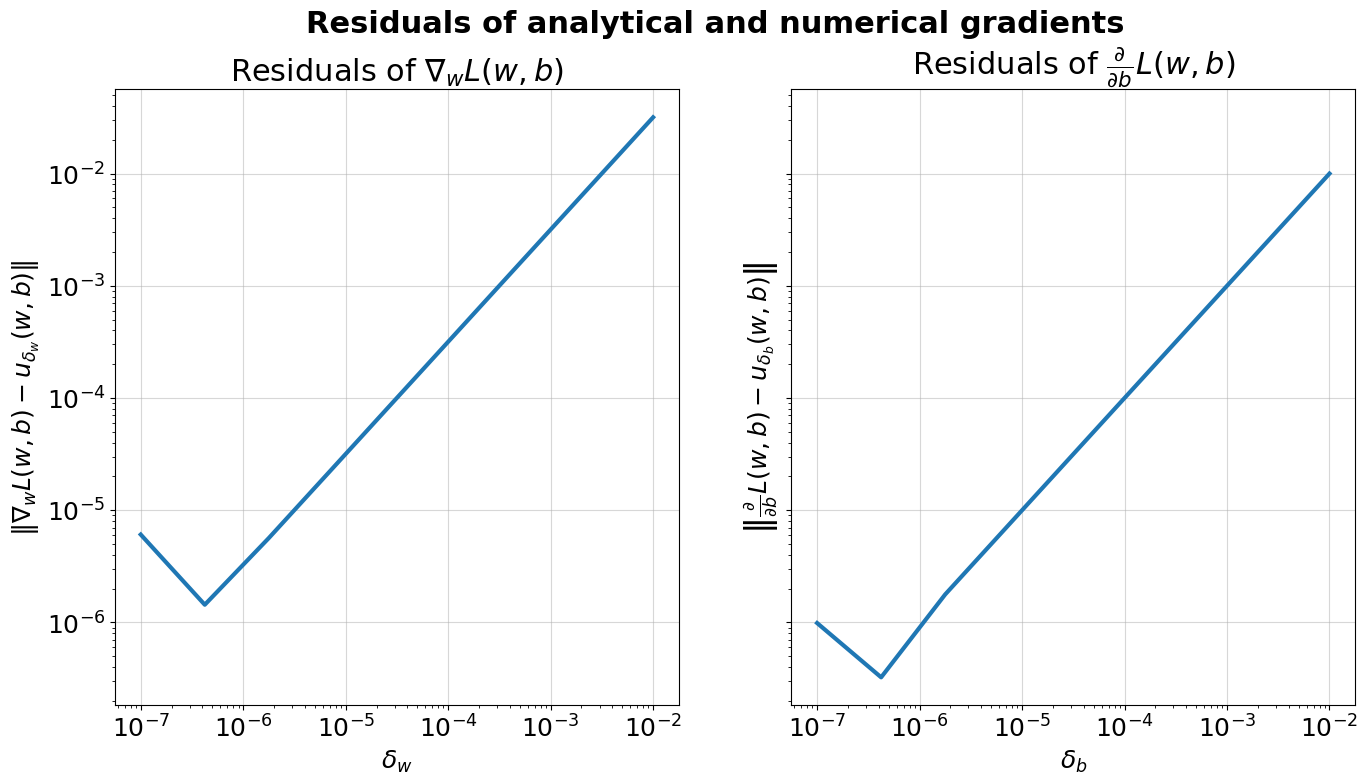

In [29]:
from verify_gradients import compare_gradients

compare_gradients(X_train, y_train, deltas=np.logspace(-7, -2, 9))

lr size = 1e-09, Best train loss = 404.06616443304796, Best validation loss = 372.9092065289827
lr size = 1e-08, Best train loss = 404.02708013504116, Best validation loss = 372.87224644931945
lr size = 1e-07, Best train loss = 403.63651538573913, Best validation loss = 372.5029102905511
lr size = 1e-06, Best train loss = 399.75855737092184, Best validation loss = 368.8358852714388
lr size = 1e-05, Best train loss = 363.6190297994325, Best validation loss = 334.676553468738
lr size = 0.0001, Best train loss = 173.40734534090547, Best validation loss = 155.7942352513141
lr size = 0.001, Best train loss = 91.6535283090169, Best validation loss = 86.32239721473198
lr size = 0.01, Best train loss = 85.7317376868268, Best validation loss = 85.70746314884025
lr size = 0.1, Best train loss = 86.80204697542752, Best validation loss = 85.11525117403067


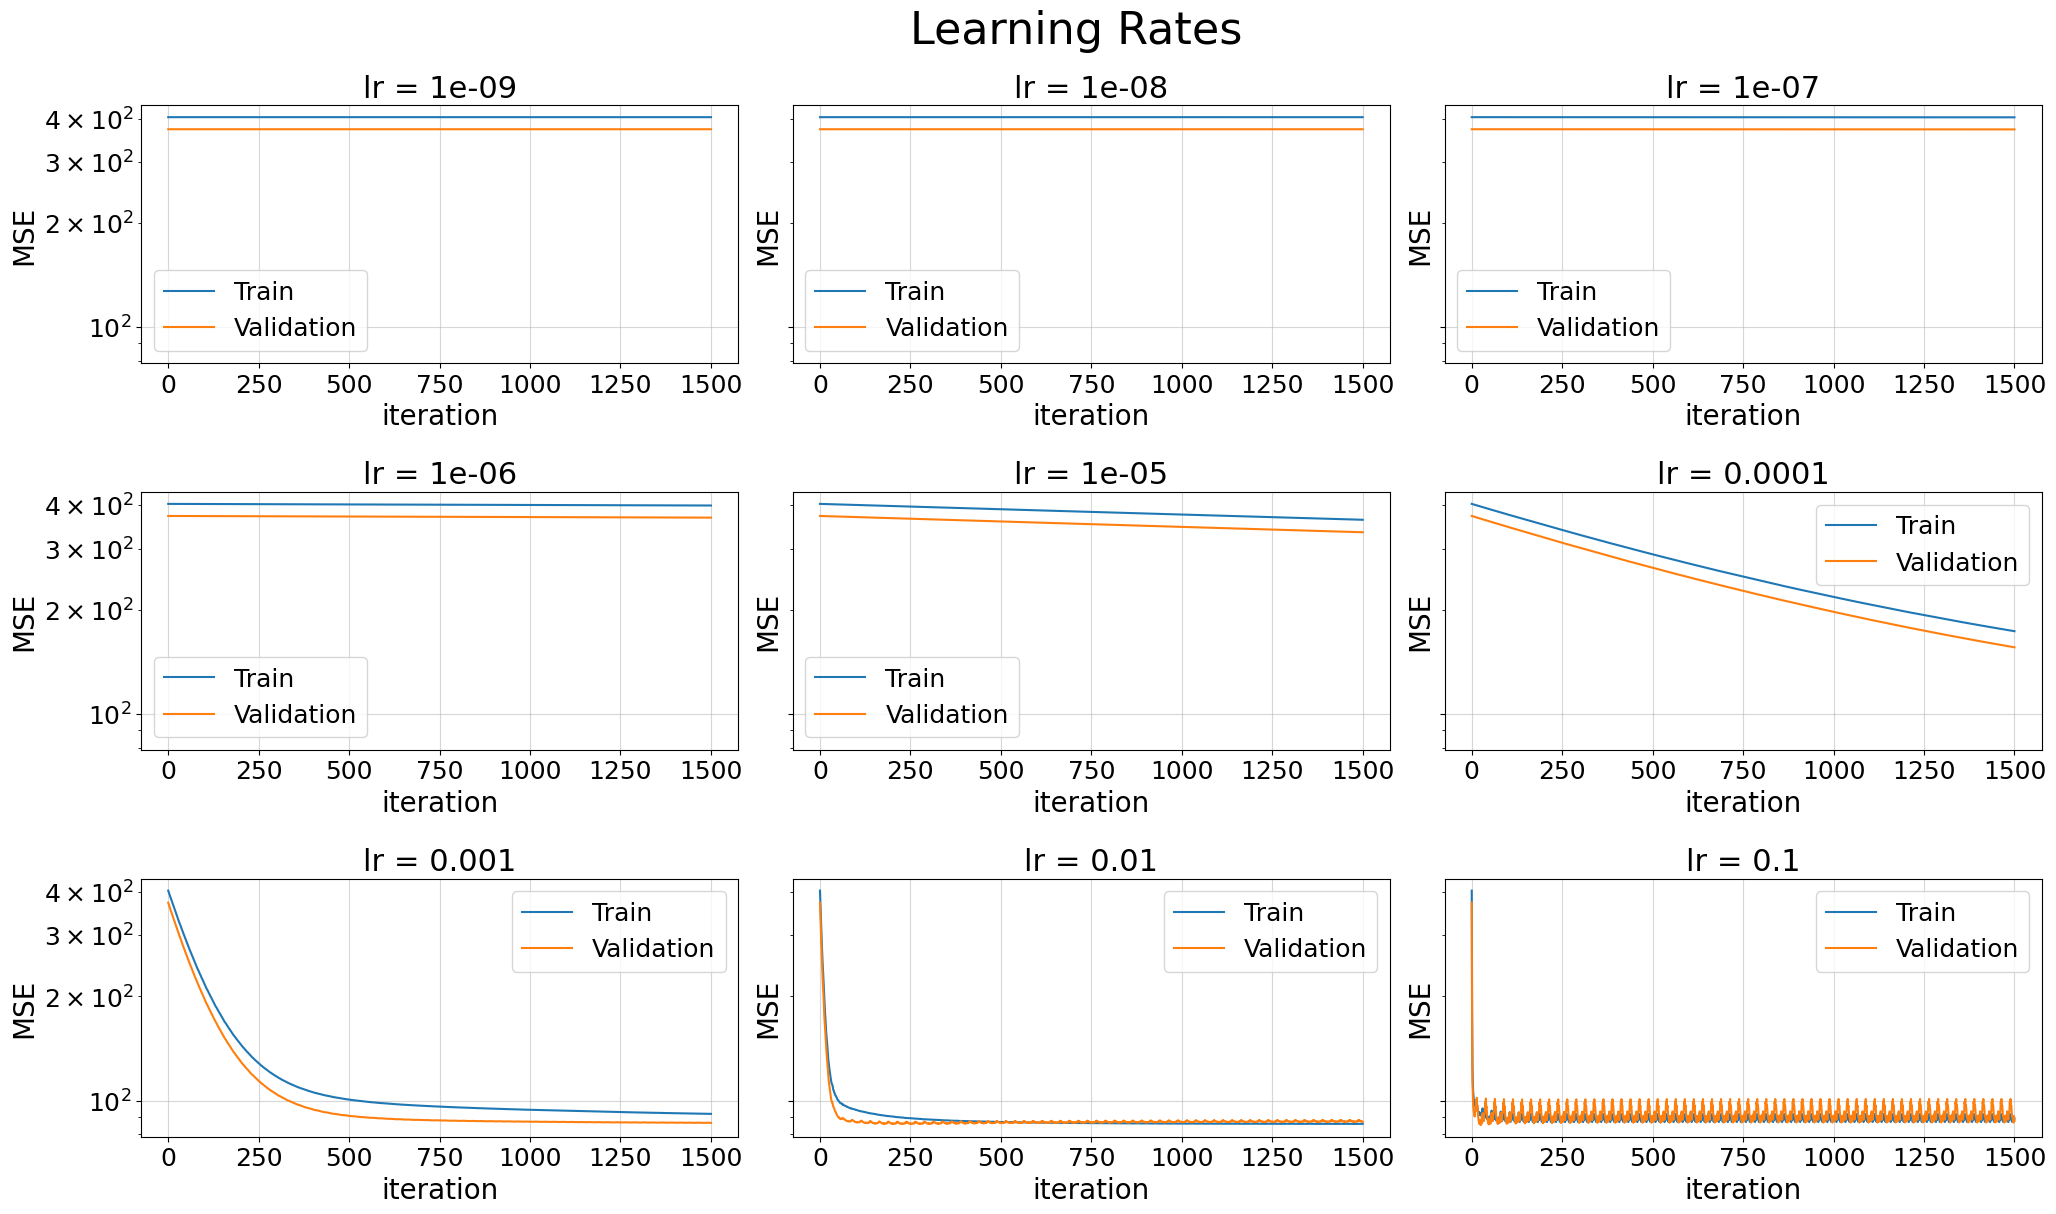

In [13]:
from test_lr import test_lr

test_lr(X_train, y_train, X_val, y_val, title="Learning Rates")

Section 2

In [97]:
# Q4 - dummy regressor

# we use the entire set now
X_train = train.drop(columns=["contamination_level"])
y_train = train["contamination_level"]

X_test = test.drop(columns=["contamination_level"])
y_test = test["contamination_level"]

from sklearn.dummy import DummyRegressor
from sklearn.model_selection import cross_validate
from sklearn.metrics import mean_squared_error

dummy_model = DummyRegressor(strategy="mean")
dummy_model_mse = cross_validate(dummy_model, X_train, y_train, cv=5, scoring="neg_mean_squared_error", return_train_score=True)
dummy_model_train_mse = np.mean(-dummy_model_mse["train_score"])
dummy_model_val_mse = np.mean(-dummy_model_mse["test_score"])
print("Dummy model train MSE: {:.2f}".format(dummy_model_train_mse))
print("Dummy model val MSE: {:.2f}".format(dummy_model_val_mse))

# now we train on entire train set and test on test set
dummy_model.fit(X_train, y_train)
y_predict = dummy_model.predict(X_test)
dummy_model_test_score = mean_squared_error(y_test, y_predict)
print("Dummy model test MSE: {:.2f}".format(dummy_model_test_score))

Dummy model train MSE: 98.79
Dummy model val MSE: 98.94
Dummy model test MSE: 109.55


In [81]:
# Q5 - linear regressor

from LinearRegressor import LinearRegressor

learning_rates = np.logspace(-9, -1, 9)
cv_test_scores = []
cv_train_scores = []

for lr in learning_rates:
    linear_regressor = LinearRegressor(lr)
    cv_scores = cross_validate(linear_regressor, X_train, y_train, cv=5, scoring="neg_mean_squared_error", return_train_score=True, n_jobs=-1)
    cv_train_scores.append(np.mean(-cv_scores["train_score"]))
    cv_test_scores.append(np.mean(-cv_scores["test_score"]))

Best learning rate:  0.01
Train MSE: 84.76
Validation MSE: 92.24


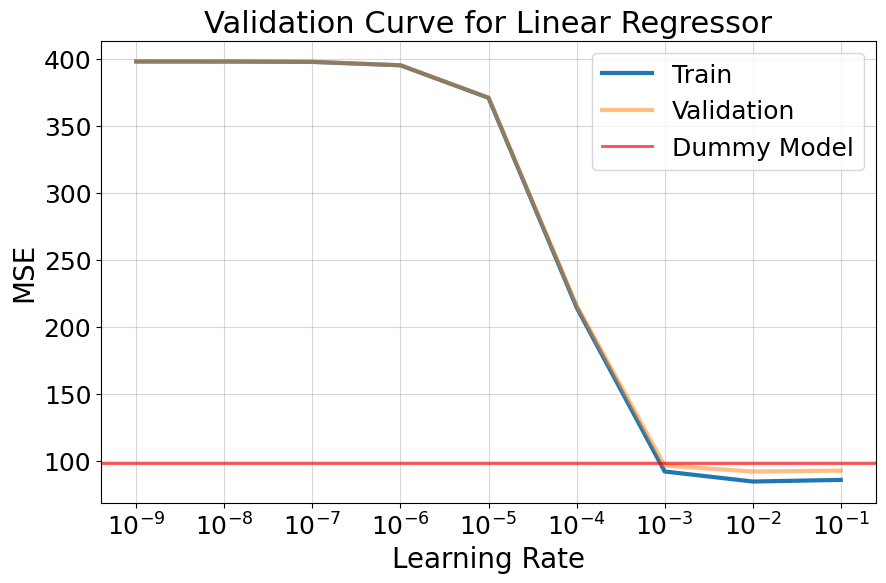

In [102]:
# plotting the results

best_lr = learning_rates[np.argmin(cv_test_scores)]
print("Best learning rate: ", best_lr)
print("Train MSE: {:.2f}".format(cv_train_scores[np.argmin(cv_test_scores)]))
print("Validation MSE: {:.2f}".format(cv_test_scores[np.argmin(cv_test_scores)]))

plt.figure(figsize=(10, 6))
plt.title("Validation Curve for Linear Regressor", fontsize=22)
plt.plot(learning_rates, cv_train_scores, label="Train", linewidth=3)
plt.plot(learning_rates, cv_test_scores, label="Validation", linewidth=3, alpha=0.5)
plt.xlabel("Learning Rate", fontsize=20)
plt.ylabel("MSE", fontsize=20)
plt.grid(alpha=0.5)
plt.semilogx()
plt.xticks(learning_rates)
# plotting the dummy model
plt.axhline(dummy_model_val_mse, color="red", label="Dummy Model", linewidth=2, alpha=0.7)
plt.legend()
plt.show()

In [90]:
# training with the best learning rate

linear_regressor = LinearRegressor(best_lr)
linear_regressor.fit(X_train, y_train)
print("Loss on test set: {:.2f}".format(mean_squared_error(y_test, linear_regressor.predict(X_test))))

Loss on test set: 96.83
